In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [63]:
df = pd.read_csv('retail_orders.csv')
df

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,A995,C109,2022-12-20,P8,Home,2,1851.82,East,5,0,0
996,A996,C166,2022-08-16,P3,Clothing,2,1459.39,East,3,0,0
997,A997,C117,2022-03-07,P19,Home,1,3249.73,South,5,0,0
998,A998,C199,2022-12-01,P14,Electronics,3,3494.73,East,8,0,0


In [64]:
df.describe()

,quantity,unit_price,delivery_days,is_returned,promotion_applied
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.966000,2496.087920,5.117000,0.135000,0.190000
std,1.661808,1398.194372,2.536088,0.341895,0.392497
min,0.000000,101.180000,1.000000,0.000000,0.000000
25%,2.000000,1282.482500,3.000000,0.000000,0.000000
50%,3.000000,2463.225000,5.000000,0.000000,0.000000
75%,4.000000,3670.977500,7.000000,0.000000,0.000000
max,9.000000,4996.120000,9.000000,1.000000,1.000000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1000 non-null   object 
 1   customer_id        1000 non-null   object 
 2   order_date         1000 non-null   object 
 3   product_id         1000 non-null   object 
 4   category           1000 non-null   object 
 5   quantity           1000 non-null   int64  
 6   unit_price         1000 non-null   float64
 7   region             1000 non-null   object 
 8   delivery_days      1000 non-null   int64  
 9   is_returned        1000 non-null   int64  
 10  promotion_applied  1000 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 86.1+ KB


Q1) Write a code to detect Anomalous Sales Weeks Using Rolling Mean.
Objective: Detect unusual weekly sales (spikes or drops) using 4-week rolling mean and std dev, and check if they’re linked to promotions. Concepts: Time Series, Pandas resample, Rolling mean/std, Anomaly detection, Promotion Attribution.

In [66]:
print(df.columns)
df.head()

Index(['order_id', 'customer_id', 'order_date', 'product_id', 'category',
       'quantity', 'unit_price', 'region', 'delivery_days', 'is_returned',
       'promotion_applied'],
      dtype='object')


,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0


In [67]:
df['sales']=df['quantity']*df['unit_price']
df['order_date']=pd.to_datetime(df['order_date'])
df

,order_id,customer_id,order_date,product_id,category,quantity,unit_price,region,delivery_days,is_returned,promotion_applied,sales
0,A0,C151,2022-02-03,P7,Mobile,0,738.56,East,1,0,0,0.00
1,A1,C192,2022-04-21,P10,Home,3,1793.57,North,4,0,0,5380.71
2,A2,C114,2022-09-21,P19,Home,0,4057.74,North,2,1,1,0.00
3,A3,C171,2022-08-24,P19,Clothing,3,1307.11,West,8,0,1,3921.33
4,A4,C160,2022-03-24,P12,Clothing,1,409.94,North,3,0,0,409.94
...,...,...,...,...,...,...,...,...,...,...,...,...
995,A995,C109,2022-12-20,P8,Home,2,1851.82,East,5,0,0,3703.64
996,A996,C166,2022-08-16,P3,Clothing,2,1459.39,East,3,0,0,2918.78
997,A997,C117,2022-03-07,P19,Home,1,3249.73,South,5,0,0,3249.73
998,A998,C199,2022-12-01,P14,Electronics,3,3494.73,East,8,0,0,10484.19



=== PROMOTION ATTRIBUTION ON ANOMALIES ===
Total Anomalies: 0
Promo Anomalies: 0
Non-Promo Anomalies: 0
Promo Share: 0%

=== ANOMALOUS WEEKS ===
Empty DataFrame
Columns: [weekly_sales, roll_mean, roll_std, z_score, direction, is_promo]
Index: []
Plotting failed. Possibly headless environment.


C:\Users\Sivaperumalraj G\AppData\Local\Temp\ipykernel_8608\4102790957.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly['z_score'].fillna(0, inplace=True)


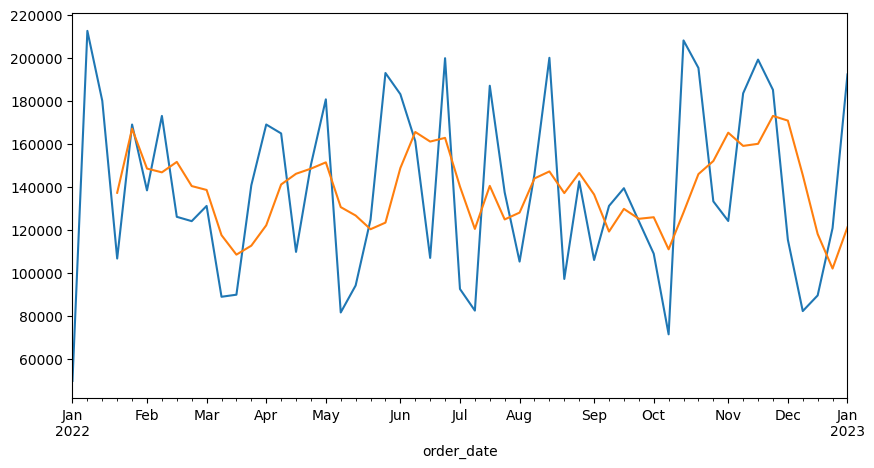

In [68]:
weekly = df.set_index('order_date').resample('W-MON').agg({
    'sales': 'sum',
    'promotion_applied': 'max'  
})

weekly.rename(columns={'sales': 'weekly_sales', 'promotion_applied': 'is_promo'}, inplace=True)
weekly['is_promo'] = weekly['is_promo'].astype(bool)

ROLL_WIN = 4
Z_THRESH = 1.5

weekly['roll_mean'] = weekly['weekly_sales'].rolling(ROLL_WIN, min_periods=ROLL_WIN).mean()
weekly['roll_std'] = weekly['weekly_sales'].rolling(ROLL_WIN, min_periods=ROLL_WIN).std()

weekly['z_score'] = (weekly['weekly_sales'] - weekly['roll_mean']) / weekly['roll_std'].replace(0, np.nan)
weekly['z_score'].fillna(0, inplace=True)


weekly['is_anomaly'] = weekly['z_score'].abs() > Z_THRESH
weekly['direction'] = np.where(weekly['weekly_sales'] > weekly['roll_mean'], 'spike', 'drop')


anomalies = weekly[weekly['is_anomaly']]
promo_anoms = anomalies['is_promo'].sum()
total_anoms = len(anomalies)

print("\n=== PROMOTION ATTRIBUTION ON ANOMALIES ===")
print(f"Total Anomalies: {total_anoms}")
print(f"Promo Anomalies: {promo_anoms}")
print(f"Non-Promo Anomalies: {total_anoms - promo_anoms}")
print(f"Promo Share: {round(100 * promo_anoms / total_anoms, 2) if total_anoms else 0}%")

print("\n=== ANOMALOUS WEEKS ===")
print(anomalies[['weekly_sales', 'roll_mean', 'roll_std', 'z_score', 'direction', 'is_promo']])


try:
    ax = weekly['weekly_sales'].plot(label='Weekly Sales', figsize=(10,5))
    weekly['roll_mean'].plot(ax=ax, label=f'{ROLL_WIN}-week Rolling Mean')
    ax.scatter(weekly.index[weekly['is_anomaly']],
               weekly.loc[weekly['is_anomaly'], 'weekly_sales'],
               color='red', label='Anomalies', zorder=5)
    plt.title("Weekly Sales & Anomalies")
    plt.legend()
    plt.tight_layout()
    plt.show()
except:
    print("Plotting failed. Possibly headless environment.")

Q2) Write a code to detect Z-Test for Return Rate Differences by Region.
Objective: Use inferential statistics to test if return rates differ significantly between regions. Concepts: Two-proportion Z-test, p-value, statistical significance.

In [69]:

region_stats = df.groupby('region')['is_returned'].agg(['sum', 'count']).rename(columns={'sum': 'returns', 'count': 'total_orders'})
region_stats['return_rate'] = region_stats['returns'] / region_stats['total_orders']

print(region_stats)

alpha = 0.05

for region1, region2 in combinations(region_stats.index, 2):
    count = [region_stats.loc[region1, 'returns'], region_stats.loc[region2, 'returns']]
    nobs  = [region_stats.loc[region1, 'total_orders'], region_stats.loc[region2, 'total_orders']]

    stat, pval = proportions_ztest(count, nobs)

    print(f"{region1} vs {region2}")
    print(f"  Z-Statistic = {stat:.4f}")
    print(f"  p-value     = {pval:.4f}")

    if pval < alpha:
        print("Significant difference in return rates")
    else:
        print("No significant difference")

        returns  total_orders  return_rate
region                                    
East         34           276     0.123188
North        30           250     0.120000
South        38           242     0.157025
West         33           232     0.142241
East vs North
  Z-Statistic = 0.1117
  p-value     = 0.9111
No significant difference
East vs South
  Z-Statistic = -1.1107
  p-value     = 0.2667
No significant difference
East vs West
  Z-Statistic = -0.6322
  p-value     = 0.5273
No significant difference
North vs South
  Z-Statistic = -1.1896
  p-value     = 0.2342
No significant difference
North vs West
  Z-Statistic = -0.7238
  p-value     = 0.4692
No significant difference
South vs West
  Z-Statistic = 0.4509
  p-value     = 0.6521
No significant difference


Q3) Write a code to predict returns and cost evaluation.
Objective: Train a machine learning model to predict returns and calculate business cost of false predictions. Skills: LabelEncoder, RandomForestClassifier, f1_score, roc_auc_score, custom cost evaluation

In [70]:

df1 = df.dropna(subset=['is_returned'])


features = ['region', 'category', 'sales', 'quantity']
target = 'is_returned'

le = LabelEncoder()
for col in ['region', 'category']:
    df1[col] = le.fit_transform(df1[col])

X = df1[features]
y = df1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

cost_fn = fn * 1000
cost_fp = fp * 100
total_cost = cost_fn + cost_fp

print(f"False Negatives (Missed Returns): {fn} x ₹1000 = ₹{cost_fn}")
print(f"False Positives (Unnecessary Flagging): {fp} x ₹100 = ₹{cost_fp}")
print(f"Total Business Cost due to wrong predictions: ₹{total_cost}")

F1 Score: 0.0000
ROC AUC Score: 0.4423
False Negatives (Missed Returns): 28 x ₹1000 = ₹28000
False Positives (Unnecessary Flagging): 7 x ₹100 = ₹700
Total Business Cost due to wrong predictions: ₹28700


Q4) Write a code to Segment Customers by Order Volatility
Objective: Segment customers by how much their order value varies, using NumPy quantiles, and compare return rates across segments. Concepts: Feature engineering, customer segmentation, NumPy quantiles, volatility.

In [77]:
customer_volatility = df.groupby('customer_id')['sales'].std().reset_index()
customer_volatility.columns = ['customer_id', 'order_volatility']


customer_volatility['order_volatility'] = customer_volatility['order_volatility'].fillna(0)


customer_volatility['volatility_segment'] = pd.qcut(customer_volatility['order_volatility'], 
                                                     q=4, labels=['Low', 'Medium', 'High', 'Very High'])


df = df.drop(columns=[col for col in df.columns if 'volatility_segment' in col], errors='ignore')


df = df.merge(customer_volatility[['customer_id', 'volatility_segment']], on='customer_id', how='left')


segment_return_rate = df.groupby('volatility_segment')['is_returned'].mean().reset_index()
segment_return_rate.columns = ['volatility_segment', 'return_rate']

print("Customer Volatility Segments")
print(customer_volatility.head())

print("Return Rate by Volatility Segment:")
print(segment_return_rate)

Customer Volatility Segments
  customer_id  order_volatility volatility_segment
0        C100       5997.569756               High
1        C101       6727.562063          Very High
2        C102       7564.806840          Very High
3        C103       4664.006064             Medium
4        C104       8474.574851          Very High
Return Rate by Volatility Segment:
  volatility_segment  return_rate
0                Low     0.170404
1             Medium     0.112782
2               High     0.132296
3          Very High     0.129921


C:\Users\Sivaperumalraj G\AppData\Local\Temp\ipykernel_8608\999221858.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_return_rate = df.groupby('volatility_segment')['is_returned'].mean().reset_index()
